This notebook generates figures illustrating the multi-step rollout visualization of the wave equation, included in Figure 3 of the main text and described in Supplementary Material Section 8.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

from wave_equation import (
    compute_exact_solution_random_ic_vary_Nx, 
    plot_both_grids
)
from data_processing import (
    SimpleSerializerSettings, 
    scale_2d_array, 
    unscale_2d_array,
    serialize_2d_integers, 
    deserialize_2d_integers
)

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
# Wave equation parameters
L = 2    # Length of the spatial domain
c = 0.3  # Wave speed
T = 0.5  # Total simulation time
Nt = 25  # Number of time steps 
Nx = 14  # Number of spatial steps (excluding boundary points)
dt = T/Nt
dx = L/(Nx+1)

# Generate random initial conditions
init_cond_random = np.random.uniform(-0.5, 0.5, size=Nx)
Nx_new = 14
fig, cs, _ = plot_both_grids(L, Nx, Nx_new, init_cond_random)
plt.close(fig) 
# Serialization setup
settings = SimpleSerializerSettings(space_sep=",", time_sep=";")
input_time_steps = 16
number_of_future_predictions = 10
# Serialize the entire exact solution for all time steps
u_exact = compute_exact_solution_random_ic_vary_Nx(L, c, T, Nx, Nt, spline_obj=cs)
u_exact_scaled, vmin_exact, vmax_exact = scale_2d_array(u_exact)
u_exact_serialized = serialize_2d_integers(u_exact_scaled, settings)
u_exact_parsed = deserialize_2d_integers(u_exact_serialized, settings)
u_exact_unscaled = unscale_2d_array(u_exact_parsed, vmin_exact, vmax_exact)

In [3]:
# Load Llama-3.1-8B model data
with np.load("8B_10_step_demo_rollout.npz", allow_pickle=True) as data_8b:
    llm_max_diffs = np.array(data_8b["llm_max_diffs_8B"])
    llm_rmses = np.array(data_8b["llm_rmses_8B"])
    llm_predictions = np.array(data_8b["llm_predictions_8B"])
    fd_results = np.array(data_8b["fd_results"]).item()

# Load Llama-3.2-3B model data
with np.load("3B_10_step_demo_rollout.npz", allow_pickle=True) as data_3b:
    llm_max_diffs_3B = np.array(data_3b["llm_max_diffs_3B"])
    llm_rmses_3B = np.array(data_3b["llm_rmses_3B"])
    llm_predictions_3B = np.array(data_3b["llm_predictions_3B"])

# Load Llama-3.2-1B model data
with np.load("1B_10_step_demo_rollout.npz", allow_pickle=True) as data_1b:
    llm_max_diffs_1B = np.array(data_1b["llm_max_diffs_1B"])
    llm_rmses_1B = np.array(data_1b["llm_rmses_1B"])
    llm_predictions_1B = np.array(data_1b["llm_predictions_1B"])

# Extract results
leapfrog_max_diff = fd_results['leapfrog']['max_diff']
leapfrog_rmse = fd_results['leapfrog']['rmse']
leapfrog_predictions = fd_results['leapfrog']['predictions']
crank_nicolson_max_diff = fd_results['crank_nicolson']['max_diff']
crank_nicolson_rmse = fd_results['crank_nicolson']['rmse']
crank_nicolson_predictions = fd_results['crank_nicolson']['predictions']

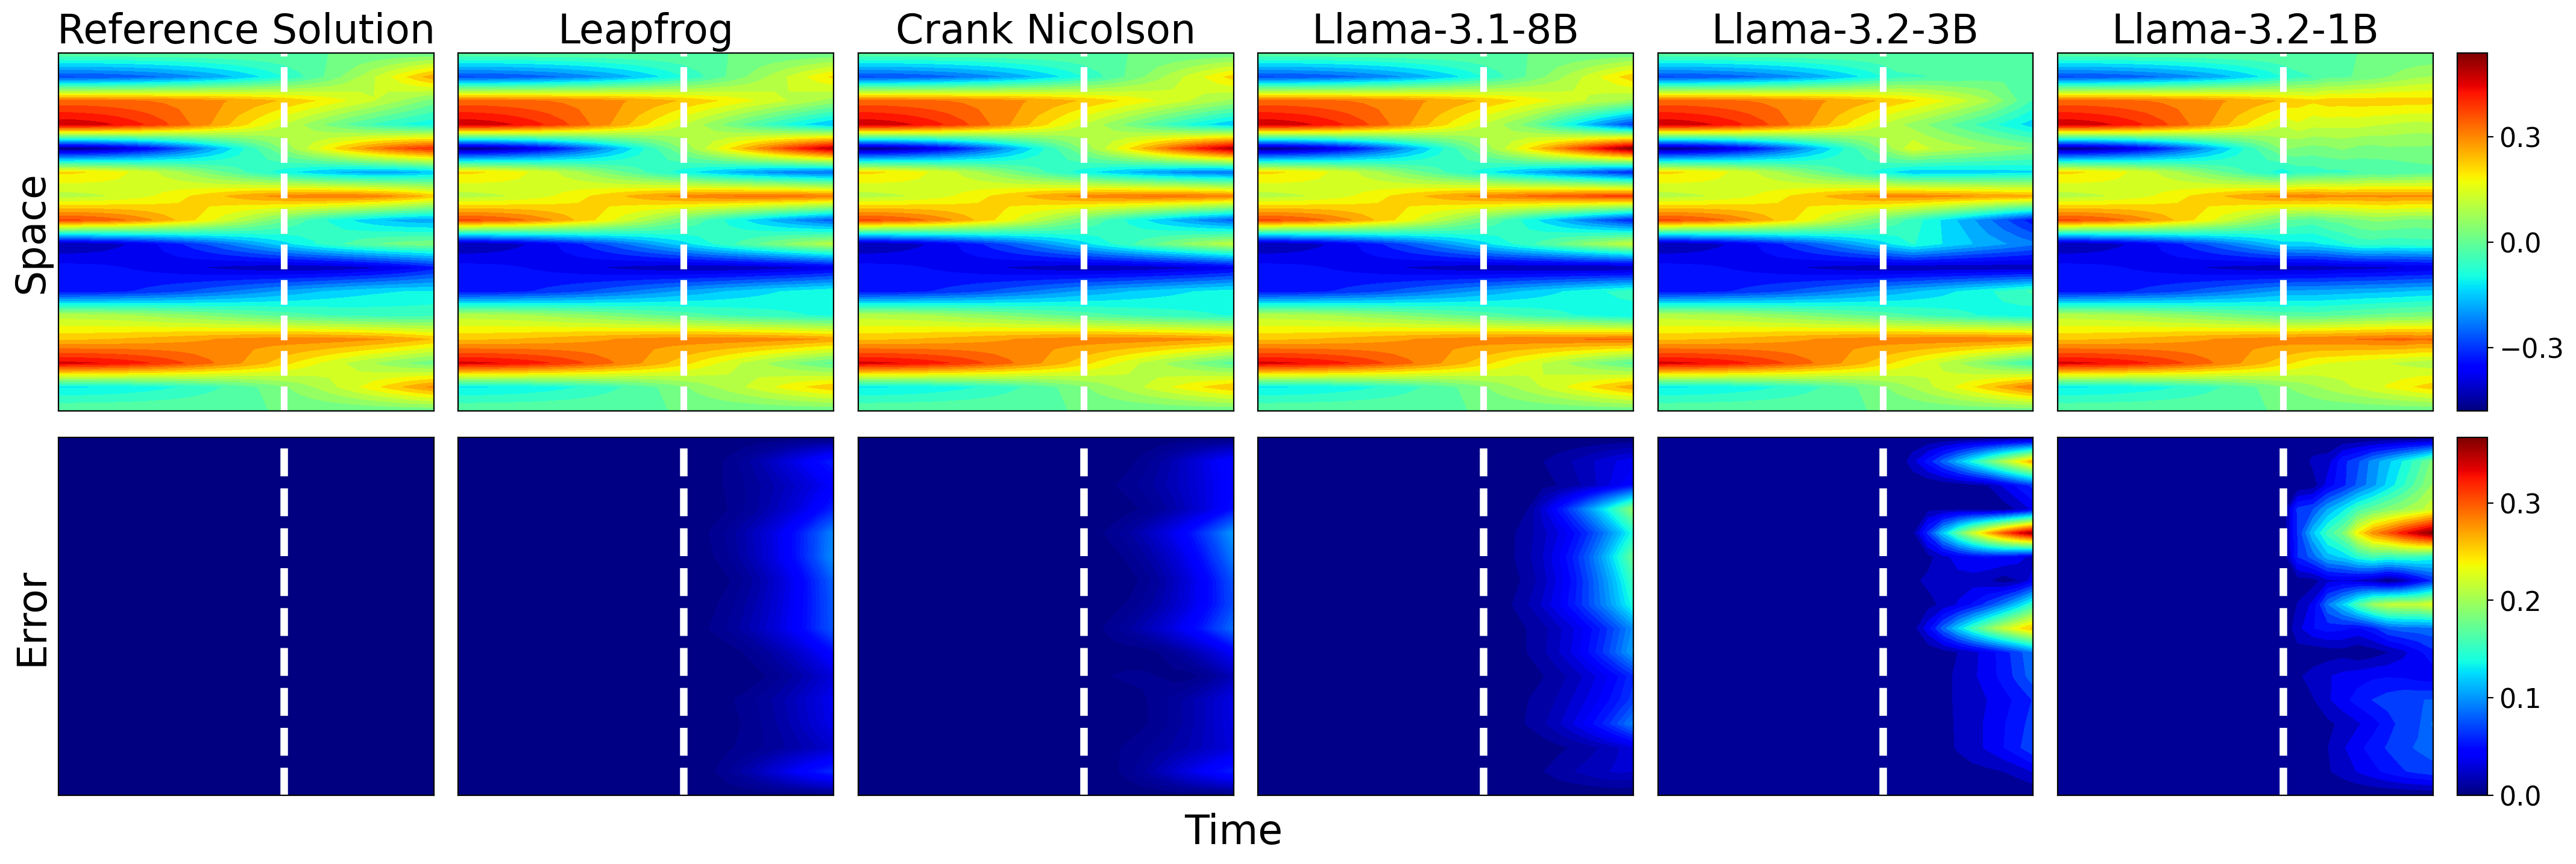

In [ ]:
def plot_solutions_with_errors():
    # Normalized domain parameters
    L = 1.0
    T = 1.0
    Nt_plus1, Nx = u_exact.shape
    # Create spatial and temporal grids
    x_full = np.linspace(-L/2, L/2, Nx+2)
    t = np.linspace(0, T, Nt_plus1)
    models = [u_exact, u_leapfrog, u_crank_nicolson, u_llama_8b, u_llama_3b, u_llama_1b]
    titles = ['Reference Solution', 'Leapfrog', 'Crank Nicolson', 'Llama-3.1-8B', 'Llama-3.2-3B', 'Llama-3.2-1B']
    fig = plt.figure(figsize=(26, 8), dpi=200)
    gs = fig.add_gridspec(2, 7, width_ratios=[1]*6 + [0.08], height_ratios=[1, 1], wspace=0.075, hspace=0.075)
    vmin_sol = min(np.min(model) for model in models)
    vmax_sol = max(np.max(model) for model in models)
    mappable_sol = plt.cm.ScalarMappable(cmap='jet')
    mappable_sol.set_clim(vmin_sol, vmax_sol)
    errors = []
    errors.append(np.zeros((Nt_plus1 - 16, Nx)))
    for i, model in enumerate(models[1:]):  # Skip reference solution
        error = np.abs(model[16:, :] - u_exact[16:, :])
        errors.append(error)
    vmax_err = max(np.max(error) for error in errors[1:])  # Skip the zero error
    mappable_err = plt.cm.ScalarMappable(cmap='jet')
    mappable_err.set_clim(0, vmax_err)
    for i, (model, title) in enumerate(zip(models, titles)):
        ax = fig.add_subplot(gs[0, i])
        model_full = np.empty((Nt_plus1, Nx+2))
        model_full[:, 1:-1] = model
        model_full[:, [0, -1]] = 0.0
        ax.contourf(t, x_full, model_full.T, levels=30, cmap='jet', vmin=vmin_sol, vmax=vmax_sol)
        ax.set_title(title, fontsize=24)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axvline(t[15], color='white', linestyle='--', linewidth=4)
        if i == 0:
            ax.set_ylabel('Space', fontsize=24)
    for i, (error, title) in enumerate(zip(errors, titles)):
        ax = fig.add_subplot(gs[1, i])
        error_full = np.zeros((Nt_plus1, Nx+2))
        error_full[16:, 1:-1] = error
        ax.contourf(t, x_full, error_full.T, levels=30, cmap='jet', vmin=0, vmax=vmax_err)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axvline(t[15], color='white', linestyle='--', linewidth=4.5)
        if i == 0:
            ax.set_ylabel('Error', fontsize=24)
    fig.text(0.5, 0.06, 'Time', fontsize=24, ha='center')
    cax_sol = fig.add_subplot(gs[0, -1])
    cbar_sol = fig.colorbar(mappable_sol, cax=cax_sol)
    cbar_sol.ax.tick_params(labelsize=16)
    cbar_sol.locator = plt.MaxNLocator(nbins=4)
    cbar_sol.update_ticks()
    cax_err = fig.add_subplot(gs[1, -1])
    cbar_err = fig.colorbar(mappable_err, cax=cax_err)
    cbar_err.ax.tick_params(labelsize=16)
    cbar_err.locator = plt.MaxNLocator(nbins=4)
    cbar_err.update_ticks()
    plt.show()

u_llama_8b = u_exact.copy()
u_llama_8b[16:, :] = llm_predictions[:, 0, :]
u_llama_3b = u_exact.copy()
u_llama_3b[16:, :] = llm_predictions_3B[:, 0, :]
u_llama_1b = u_exact.copy()
u_llama_1b[16:, :] = llm_predictions_1B[:, 0, :]
u_leapfrog = u_exact.copy()
u_leapfrog[16:, :] = leapfrog_predictions
u_crank_nicolson = u_exact.copy()
u_crank_nicolson[16:, :] = crank_nicolson_predictions
plot_solutions_with_errors()

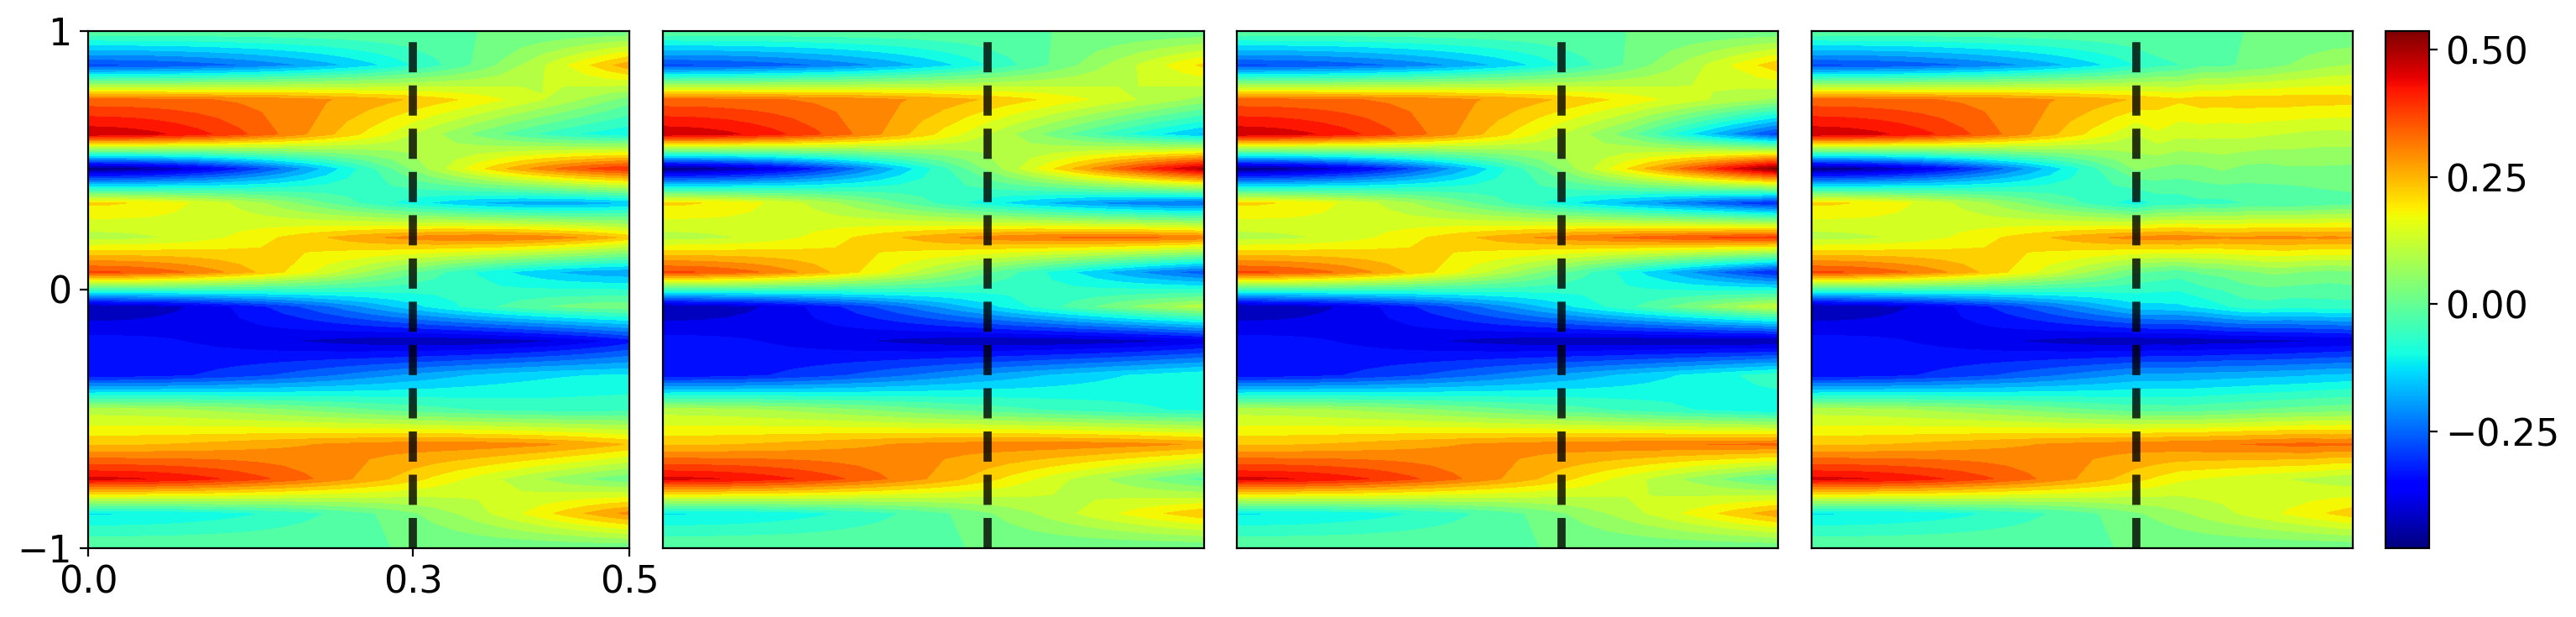

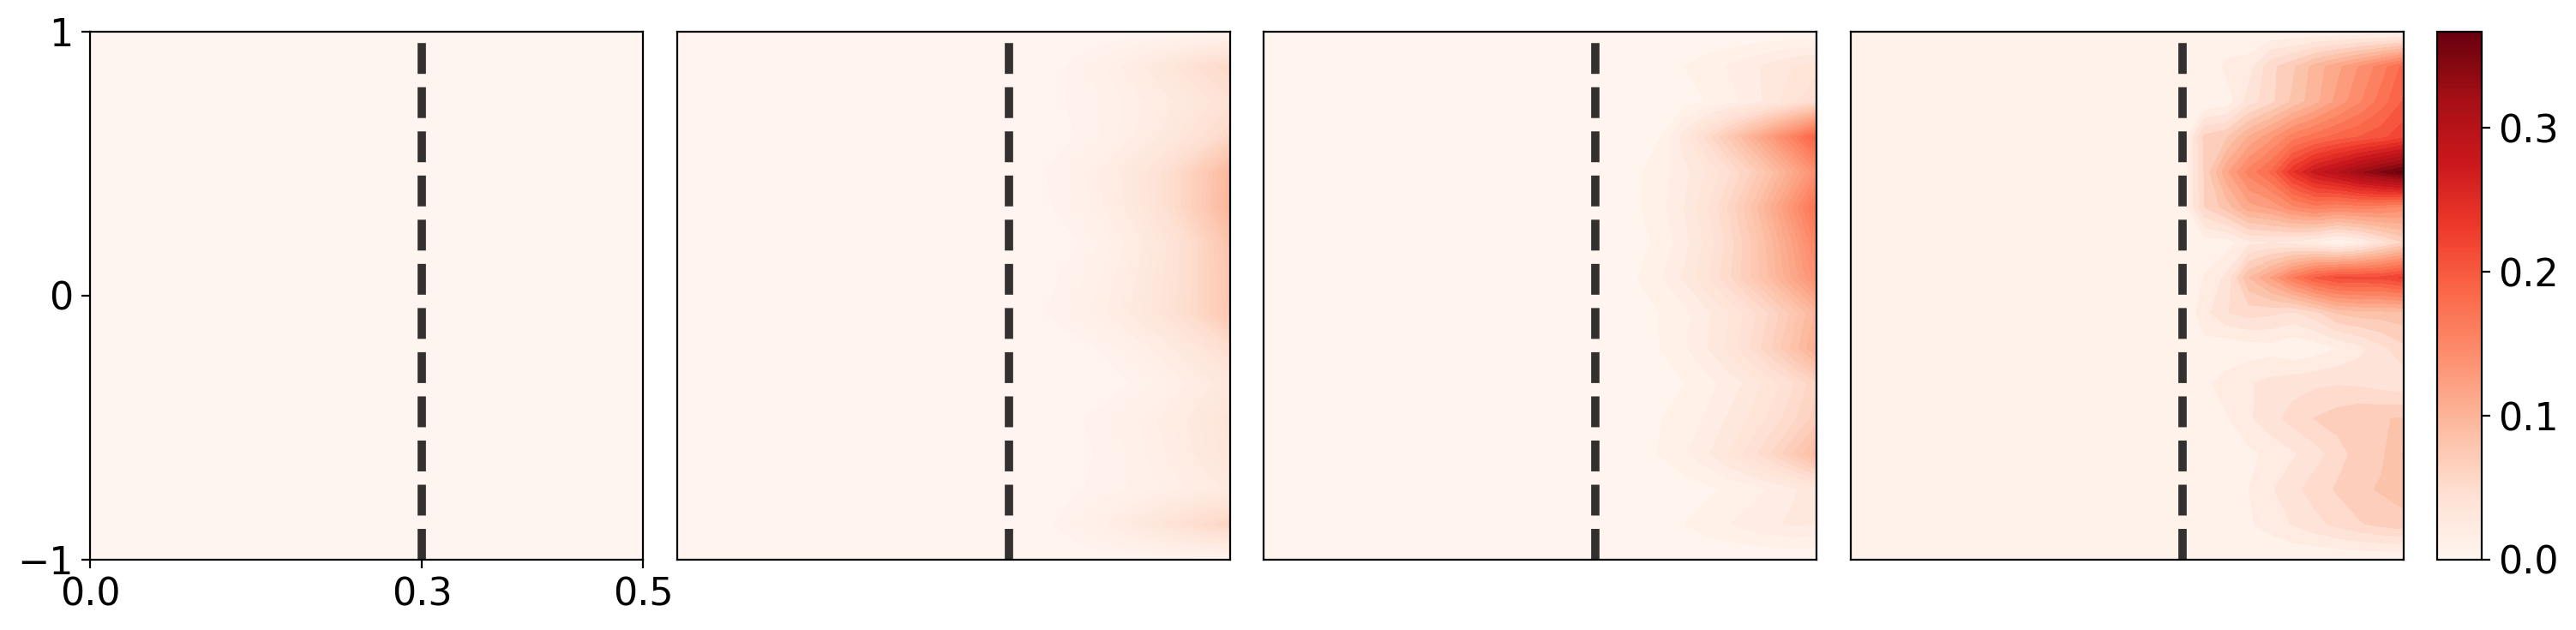

In [5]:
def plot_solutions():
    # Real scale domain parameters
    L = 2.0  
    T = 0.5  
    Nt_plus1, Nx = u_exact.shape
    x_full = np.linspace(-L/2, L/2, Nx+2)  
    t = np.linspace(0, T, Nt_plus1)        
    models = [u_exact, u_leapfrog, u_llama_8b, u_llama_1b]
    titles = ['Reference Solution', 'Finite Difference', 'Llama-3.1-8B', 'Llama-3.2-1B']
    fig = plt.figure(figsize=(18, 4), dpi=200)
    gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.08], wspace=0.075)
    vmin_sol = min(np.min(model) for model in models)
    vmax_sol = max(np.max(model) for model in models)
    mappable_sol = plt.cm.ScalarMappable(cmap='jet')
    mappable_sol.set_clim(vmin_sol, vmax_sol)
    for i, (model, title) in enumerate(zip(models, titles)):
        ax = fig.add_subplot(gs[0, i])
        model_full = np.empty((Nt_plus1, Nx+2))
        model_full[:, 1:-1] = model
        model_full[:, [0, -1]] = 0.0
        ax.contourf(t, x_full, model_full.T, levels=30, cmap='jet', vmin=vmin_sol, vmax=vmax_sol)
        if i == 0:
            ax.set_xticks([0, 0.3, 0.5])
            ax.set_yticks([-1, 0, 1])
            ax.tick_params(labelsize=16)
        else:
            ax.set_xticks([])
            ax.set_yticks([])
        ax.axvline(t[15], color='black', linestyle='--', linewidth=3.5, alpha=0.8)
    cax_sol = fig.add_subplot(gs[0, -1])
    cbar_sol = fig.colorbar(mappable_sol, cax=cax_sol)
    cbar_sol.ax.tick_params(labelsize=16)
    cbar_sol.locator = plt.MaxNLocator(nbins=5)
    cbar_sol.update_ticks()
    plt.show()


def plot_errors():
    # Real scale domain parameters
    L = 2.0  
    T = 0.5  
    Nt_plus1, Nx = u_exact.shape
    x_full = np.linspace(-L/2, L/2, Nx+2)  
    t = np.linspace(0, T, Nt_plus1)        
    models = [u_exact, u_leapfrog, u_llama_8b, u_llama_1b]
    titles = ['Reference Solution', 'Finite Difference', 'Llama-3.1-8B', 'Llama-3.2-1B']
    fig = plt.figure(figsize=(18, 4), dpi=200)
    gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.08], wspace=0.075)
    errors = []
    errors.append(np.zeros((Nt_plus1 - 16, Nx)))
    for i, model in enumerate(models[1:]):  
        error = np.abs(model[16:, :] - u_exact[16:, :])
        errors.append(error)
    vmax_err = max(np.max(error) for error in errors[1:])  
    mappable_err = plt.cm.ScalarMappable(cmap='Reds')
    mappable_err.set_clim(0, vmax_err)
    for i, (error, title) in enumerate(zip(errors, titles)):
        ax = fig.add_subplot(gs[0, i])
        error_full = np.zeros((Nt_plus1, Nx+2))
        error_full[16:, 1:-1] = error
        ax.contourf(t, x_full, error_full.T, levels=30, cmap='Reds', vmin=0, vmax=vmax_err)
        if i == 0:
            ax.set_xticks([0, 0.3, 0.5])
            ax.set_yticks([-1, 0, 1])
            ax.tick_params(labelsize=16)
        else:
            ax.set_xticks([])
            ax.set_yticks([])
        ax.axvline(t[15], color='black', linestyle='--', linewidth=3.5, alpha=0.8)
    cax_err = fig.add_subplot(gs[0, -1])
    cbar_err = fig.colorbar(mappable_err, cax=cax_err)
    cbar_err.ax.tick_params(labelsize=16)
    cbar_err.locator = plt.MaxNLocator(nbins=4)
    cbar_err.update_ticks()
    plt.show()


plot_solutions()
plot_errors()